In [1]:
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import matplotlib.pyplot as plt

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("ADS Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .getOrCreate())

your 131072x1 screen size is bogus. expect trouble
24/08/31 05:29:37 WARN Utils: Your hostname, LAPTOP-1A92TAQQ resolves to a loopback address: 127.0.1.1; using 172.18.166.45 instead (on interface eth0)
24/08/31 05:29:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/31 05:29:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 59466)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/chengmingliew/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/chengmingliew/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/home/chengmingliew/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 2

In [2]:
from pyspark.sql.functions import month, dayofmonth, hour, minute, second, dayofweek

sdf_yellow = spark.read.parquet('Processed/tlc_yellow_data/*')
sdf_yellow.limit(5)
NUM_COLS = ['tpep_pickup_datetime',
 'month',
 'day',
 'hour',
 'day_of_week',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'airport_fee',
 'duration_seconds']

# Assuming the timestamp column is named "timestamp"
sdf_yellow = sdf_yellow.withColumn("month", month("tpep_pickup_datetime")) \
       .withColumn("day", dayofmonth("tpep_pickup_datetime")) \
       .withColumn("hour", hour("tpep_pickup_datetime")) \
       .withColumn("minute", minute("tpep_pickup_datetime")) \
       .withColumn("second", second("tpep_pickup_datetime")) \
       .withColumn("day_of_week", dayofweek("tpep_pickup_datetime"))  # 1=Sunday, 7=Saturday

sdf_yellow = sdf_yellow[NUM_COLS]

sdf_yellow.limit(5)

+--------------------+-----+---+----+-----------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+----------------+
|tpep_pickup_datetime|month|day|hour|day_of_week|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|congestion_surcharge|airport_fee|duration_seconds|
+--------------------+-----+---+----+-----------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+----------------+
| 2023-05-01 00:42:49|    5|  1|   0|          2|  2023-05-01 01:11:18|              2|          8.1|         138|         262|           1|       35.9|10.25|    0.5|       9.5|         0.0|                  1.0|                 2.5|       1.75|            1709|
| 2023-05-01 00:56:34|    5|  1|   0|          2|  2023-05-01 01:13:39|              2|          9.1|         138|         141|           1|       35.2|10.25|    0.5|      10.7|        6.55|                  1.0|                 2.5|       1.75|            1025|
| 2023-05-01 00:00:52|    5|  1|   0|          2|  2023-05-01 00:20:12|              1|         8.21|         138|         140|           1|       33.1|  6.0|    0.5|      2.24|         0.0|                  1.0|                 2.5|       1.75|            1160|
| 2023-05-01 00:50:34|    5|  1|   0|          2|  2023-05-01 01:12:09|              1|         9.05|         138|         116|           1|       38.0|  6.0|    0.5|     10.76|        6.55|                  1.0|                 0.0|       1.75|            1295|
| 2023-05-01 00:13:58|    5|  1|   0|          2|  2023-05-01 00:18:10|              1|          0.7|         161|          48|           1|        6.5|  3.5|    0.5|      2.85|         0.0|                  1.0|                 2.5|        0.0|             252|
+--------------------+-----+---+----+-----------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+----------------+

In [3]:
import geopandas as gpd

# sf stands for shape file
sf = gpd.read_file("taxi_zones/taxi_zones.shp")
zones = pd.read_csv("taxi_zones/taxi+_zone_lookup.csv")

sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)

geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()

## Finding whats the average tip amount and amount of pickups according to location

In [4]:
centroid_df = gdf.to_crs("epsg:3785").centroid.to_crs(gdf.crs).get_coordinates().rename_axis('PULocationID').reset_index()
centroid_df["PULocationID"] = centroid_df['PULocationID'] + 1

In [5]:
# Geospatial Information on which area are more often to give tips than not
tip_val_location = sdf_yellow.filter(F.col('payment_type') == 1) \
                   .groupby('PULocationID') \
                   .agg(F.mean('tip_amount')) \
                   .join(sdf_yellow.groupby(F.col('PULocationID')).count(), "PULocationID") \
                   .orderBy("PULocationID", ascending=True)

tip_val_location = tip_val_location.toPandas()

### Finding and Graphing the 50 most frequent pickups of the year's tips

In [6]:
coord_df = pd.merge(tip_val_location, centroid_df, on="PULocationID", how="inner")
coord_df['avg(tip_amount)'] = coord_df['avg(tip_amount)'].apply(lambda x: round(x, 2))
coord_df.sort_values('count', ascending=False, inplace=True)
coord_df = coord_df.iloc[0:49]  

In [7]:
import folium

# Coordinates for New York City
nyc_coords = [40.7128, -73.9900]

# Create a map centered on New York City
nyc_map = folium.Map(location=nyc_coords, zoom_start=12)

folium.GeoJson(
    geoJSON,
    name='geojson'
).add_to(nyc_map)

c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=tip_val_location, # data source
    columns=['PULocationID','count'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name='Number of Pickups in 2023 by Location'
)

for _, row in coord_df.iterrows():
    folium.Marker(
        location=[row['y'], row['x']],
        icon=folium.DivIcon(
            html=f'<div style="font-size: 7pt; color : black">{row["avg(tip_amount)"]}</div>'
        )
    ).add_to(nyc_map)

c.add_to(nyc_map)

nyc_map

## Getting Weather Data

- Install the prequisite libraries first

`pip install openmeteo-requests`
`pip install requests-cache retry-requests numpy pandas`

In [8]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"start_date": "2023-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m","rain", "snow_depth", "wind_speed_10m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_rain = hourly.Variables(1).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["rain"] = hourly_rain
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)

Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 51.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


hourly_dataframe

In [9]:
hourly_dataframe['temperature_2m'] = hourly_dataframe['temperature_2m'].apply(lambda x: round(x, 2))
hourly_dataframe['wind_speed_10m'] = hourly_dataframe['wind_speed_10m'].apply(lambda x: round(x, 2))
hourly_dataframe['rain'] = hourly_dataframe['rain'].apply(lambda x: round(x, 2))
hourly_dataframe['snow_depth'] = hourly_dataframe['snow_depth'].apply(lambda x: round(x, 2))

In [10]:
hourly_spark = spark.createDataFrame(hourly_dataframe)

In [11]:
hourly_spark = hourly_spark.withColumn("month", month("date")) \
       .withColumn("day", dayofmonth("date")) \
       .withColumn("hour", hour("date")) \
       .drop("date")

### Plotting Weather Data all Year Round

In [12]:
from pyspark.sql.functions import broadcast

weather_df = sdf_yellow.join(broadcast(hourly_spark), 
                         (sdf_yellow.month == hourly_spark.month) & 
                         (sdf_yellow.day == hourly_spark.day) & 
                         (sdf_yellow.hour == hourly_spark.hour), 
                         "inner"
                        ).drop(hourly_spark['day']) \
                         .drop(hourly_spark['hour']) \
                         .drop(hourly_spark['month'])

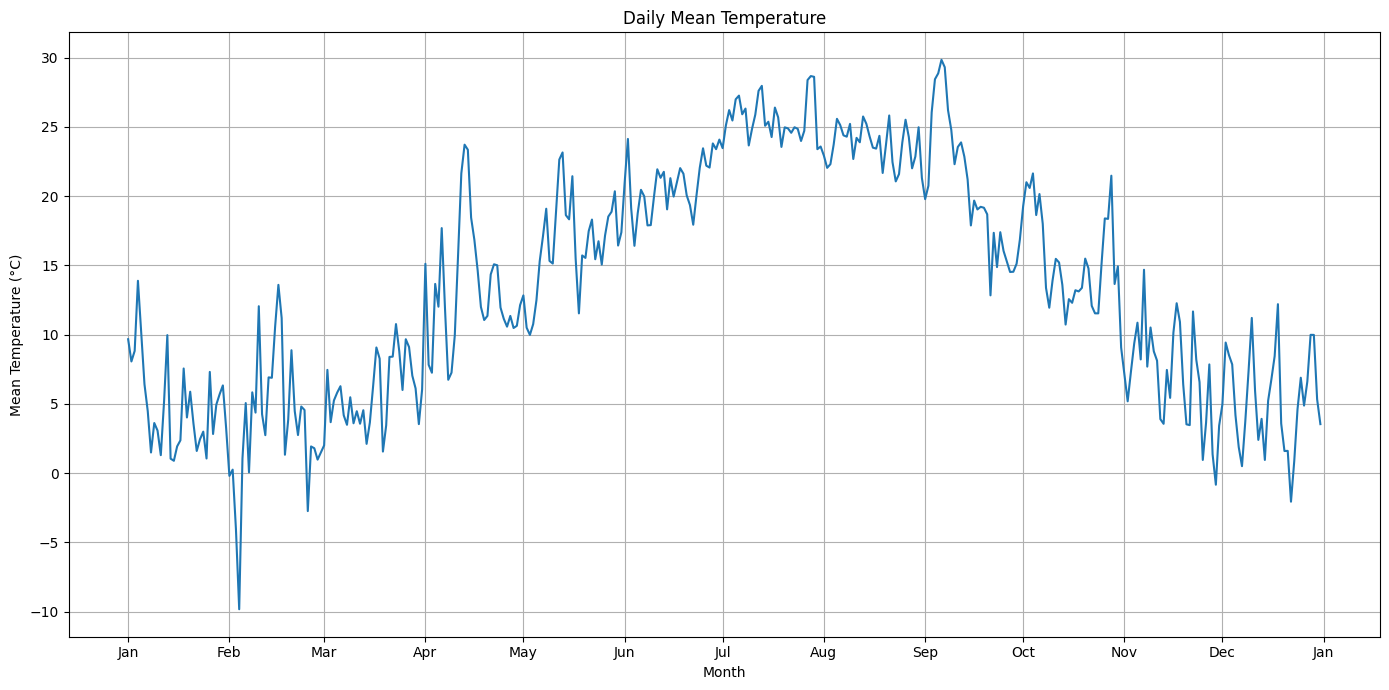

In [13]:
temp_df = weather_df.groupBy("month", "day").agg(F.mean("temperature_2m").alias("mean_temperature_2m")).orderBy("month", "day")

# Convert the PySpark DataFrame to Pandas for plotting
temp_pd_df = temp_df.toPandas()

# Create a new 'date' column by combining 'month' and 'day'
temp_pd_df['date'] = pd.to_datetime(temp_pd_df[['month', 'day']].assign(year=2024))  # You can adjust the year as needed

# Plotting the daily temperature with months on the x-axis
plt.figure(figsize=(14, 7))
plt.plot(temp_pd_df['date'], temp_pd_df['mean_temperature_2m'], linestyle='-')
plt.title('Daily Mean Temperature')
plt.xlabel('Month')
plt.ylabel('Mean Temperature (°C)')
plt.grid(True)

# Format the x-axis to show months
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))  # '%b' gives abbreviated month names (Jan, Feb, etc.)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  # Set major ticks to the start of each month

plt.tight_layout()
plt.show()

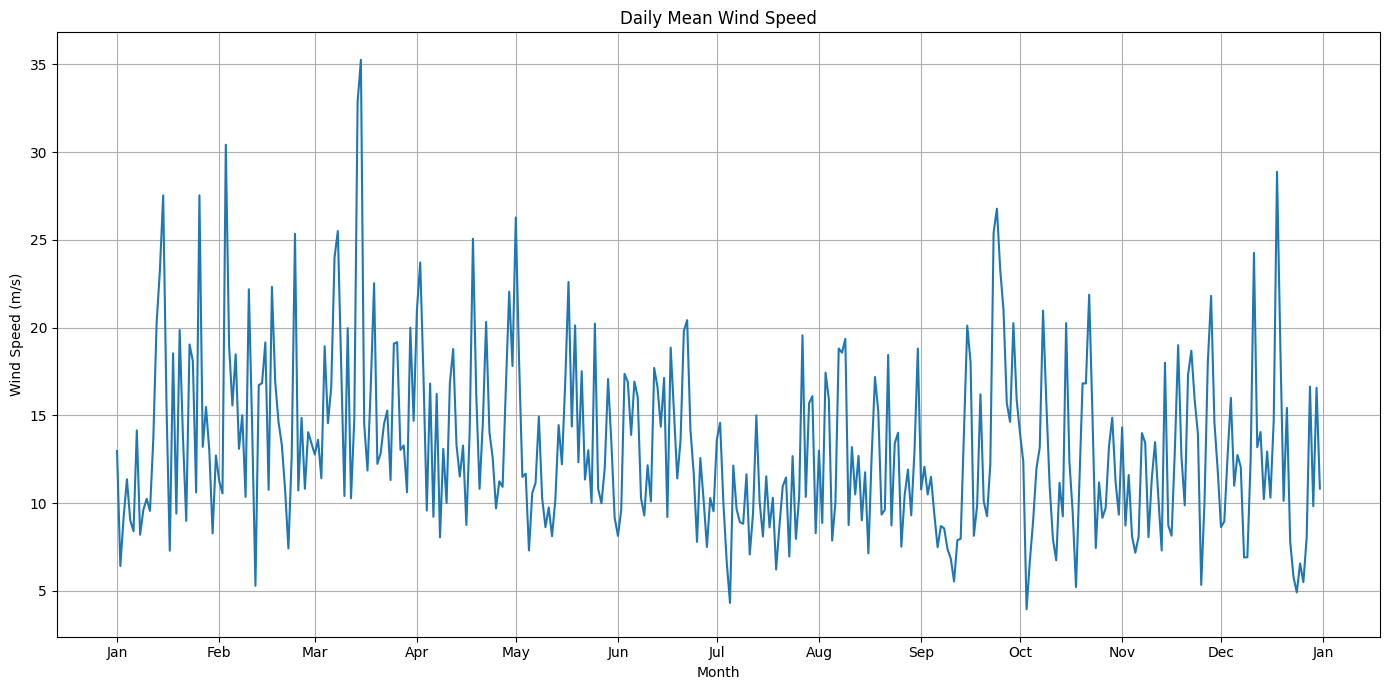

In [14]:
wind_df = weather_df.groupBy("month", "day").agg(F.mean("wind_speed_10m").alias("mean_wind_speed_10m")).orderBy("month", "day")

# Convert the PySpark DataFrame to Pandas for plotting
wind_pd_df = wind_df.toPandas()

# Create a new 'date' column by combining 'month' and 'day'
wind_pd_df['date'] = pd.to_datetime(wind_pd_df[['month', 'day']].assign(year=2024))  # You can adjust the year as needed

# Plotting the daily temperature with months on the x-axis
plt.figure(figsize=(14, 7))
plt.plot(wind_pd_df['date'], wind_pd_df['mean_wind_speed_10m'], linestyle='-')
plt.title('Daily Mean Wind Speed')
plt.xlabel('Month')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True)

# Format the x-axis to show months
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))  # '%b' gives abbreviated month names (Jan, Feb, etc.)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  # Set major ticks to the start of each month

plt.tight_layout()
plt.show()

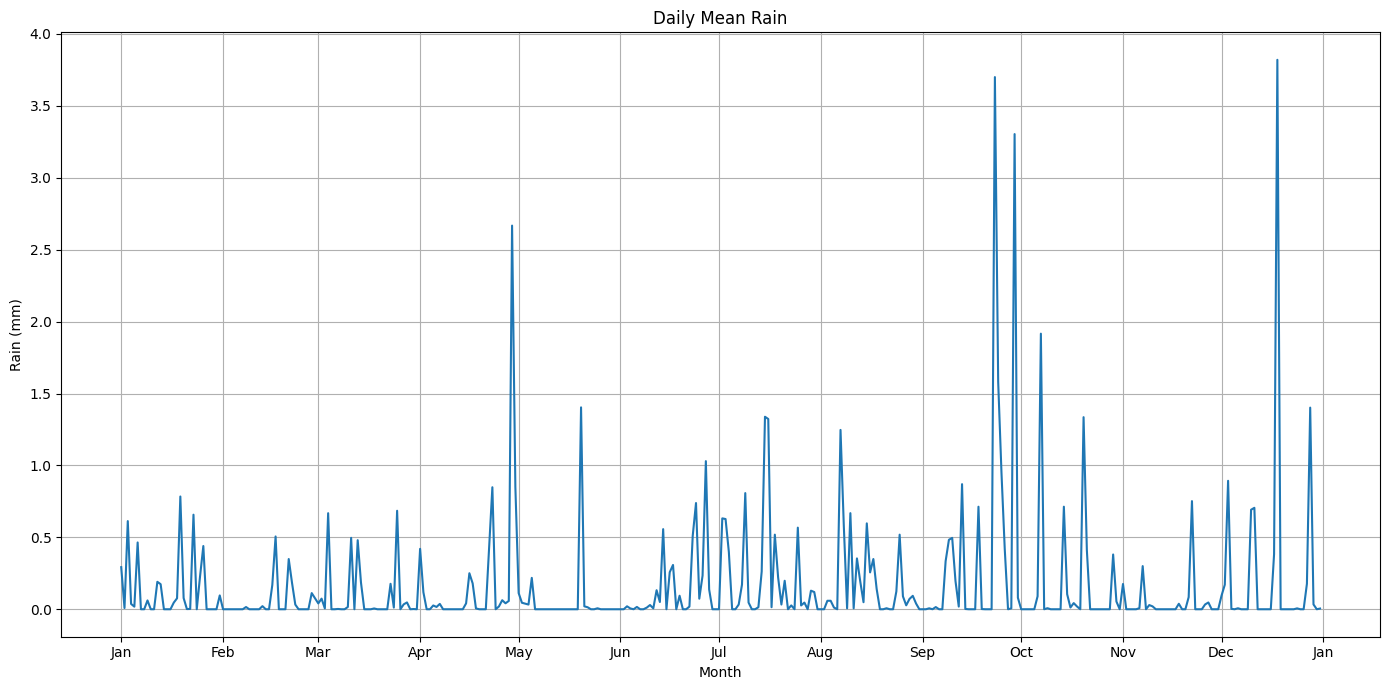

In [15]:
rain_df = weather_df.groupBy("month", "day").agg(F.mean("rain").alias("mean_rain")).orderBy("month", "day")

# Convert the PySpark DataFrame to Pandas for plotting
rain_pd_df = rain_df.toPandas()

# Create a new 'date' column by combining 'month' and 'day'
rain_pd_df['date'] = pd.to_datetime(rain_pd_df[['month', 'day']].assign(year=2024))  # You can adjust the year as needed

# Plotting the daily temperature with months on the x-axis
plt.figure(figsize=(14, 7))
plt.plot(rain_pd_df['date'], rain_pd_df['mean_rain'], linestyle='-')
plt.title('Daily Mean Rain')
plt.xlabel('Month')
plt.ylabel('Rain (mm)')
plt.grid(True)

# Format the x-axis to show months
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))  # '%b' gives abbreviated month names (Jan, Feb, etc.)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  # Set major ticks to the start of each month

plt.tight_layout()
plt.show()

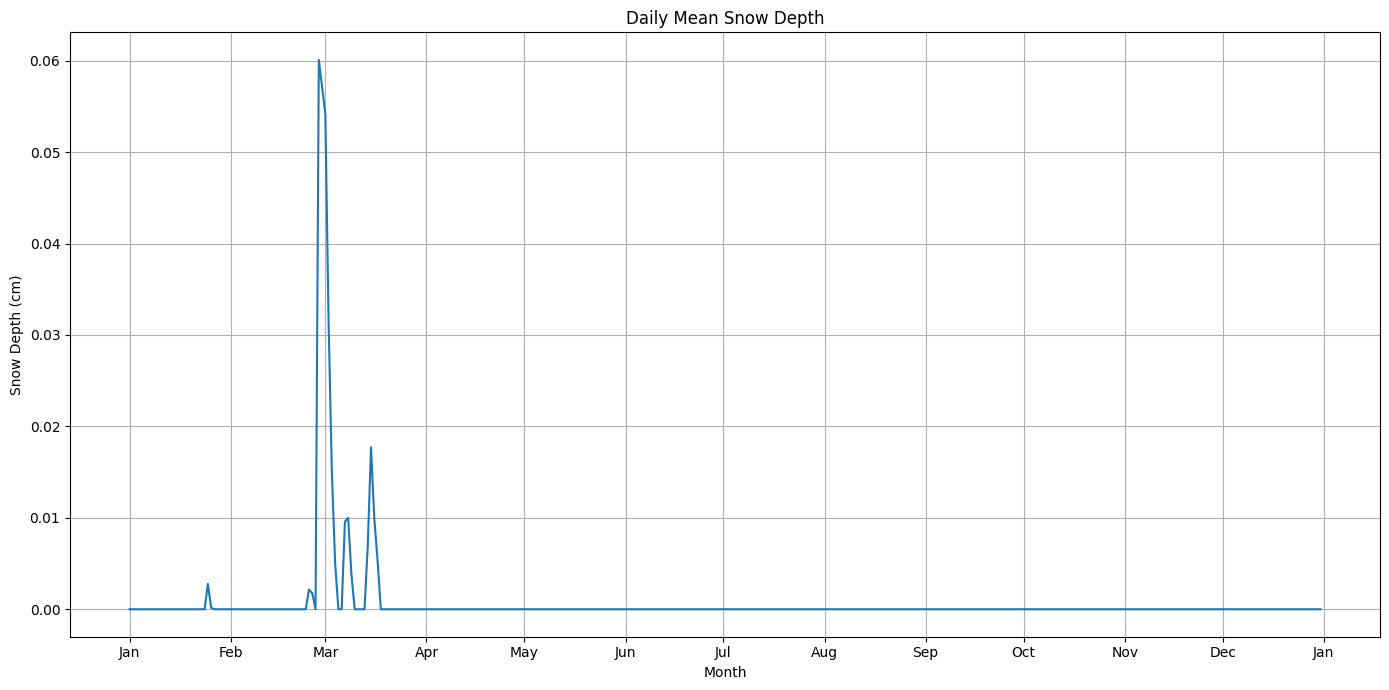

In [16]:
snow_depth_df = weather_df.groupBy("month", "day").agg(F.mean("snow_depth").alias("mean_snow_depth")).orderBy("month", "day")

# Convert the PySpark DataFrame to Pandas for plotting
snow_depth_pd_df = snow_depth_df.toPandas()

# Create a new 'date' column by combining 'month' and 'day'
snow_depth_pd_df['date'] = pd.to_datetime(snow_depth_pd_df[['month', 'day']].assign(year=2024))  # You can adjust the year as needed

# Plotting the daily temperature with months on the x-axis
plt.figure(figsize=(14, 7))
plt.plot(snow_depth_pd_df['date'], snow_depth_pd_df['mean_snow_depth'], linestyle='-')
plt.title('Daily Mean Snow Depth')
plt.xlabel('Month')
plt.ylabel('Snow Depth (cm)')
plt.grid(True)

# Format the x-axis to show months
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))  # '%b' gives abbreviated month names (Jan, Feb, etc.)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  # Set major ticks to the start of each month

plt.tight_layout()
plt.show()

### Plotting average tips against the weather features

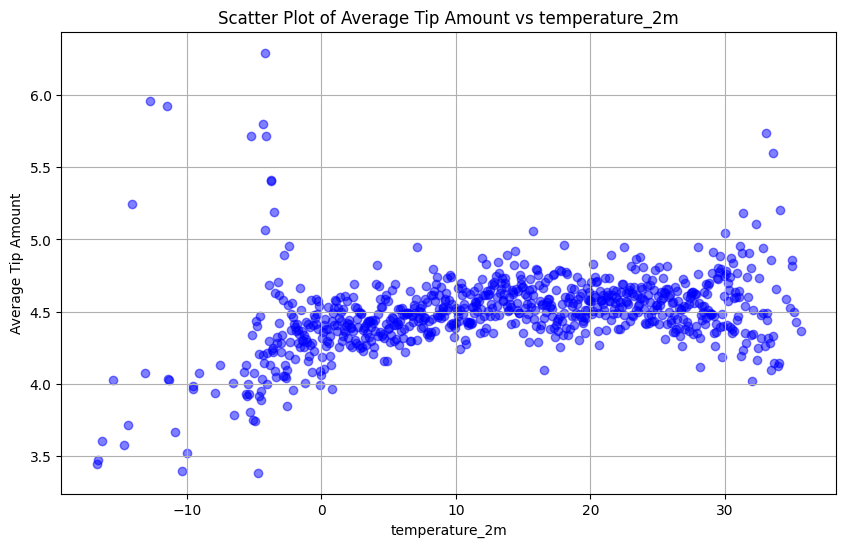

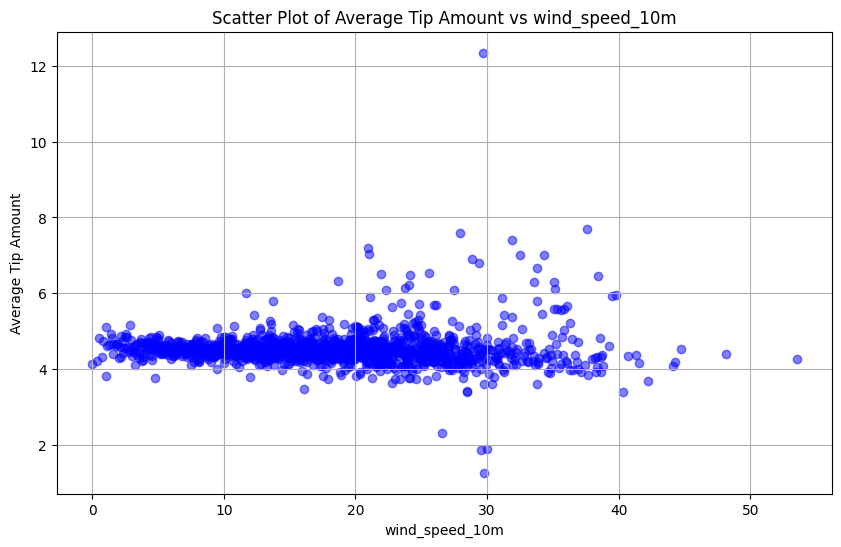

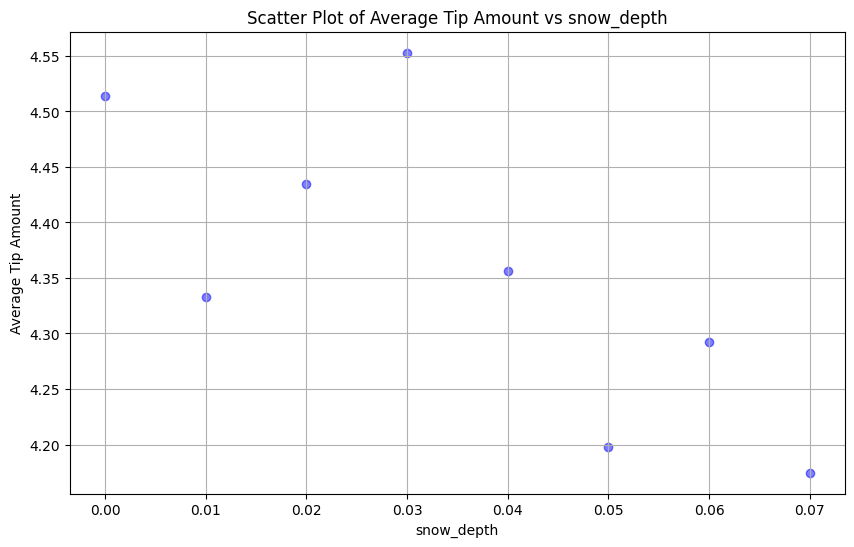

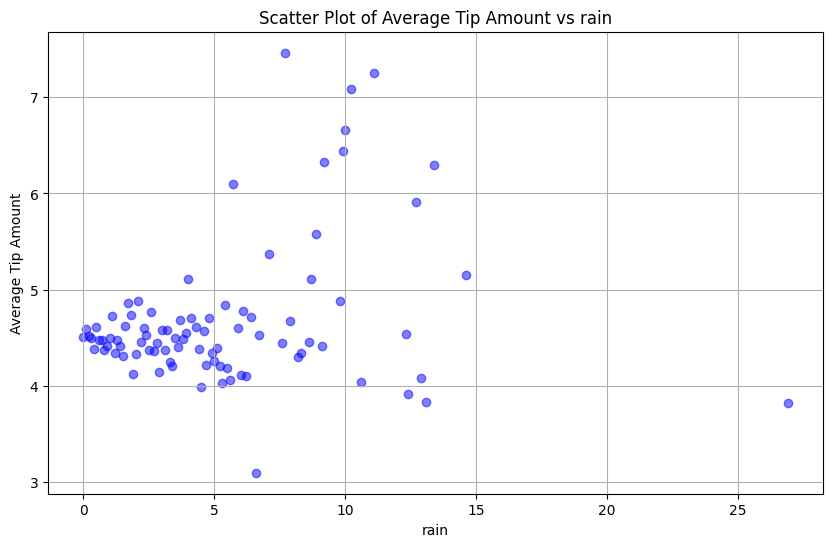

In [17]:
weather_features = ['temperature_2m', 'wind_speed_10m', 'snow_depth', 'rain']


for feature in weather_features:
    # Select the relevant columns
    tip_precipitation_df = weather_df.filter(F.col("payment_type") == 1).select('tip_amount', feature)
    avg_tip = tip_precipitation_df.groupby(feature).agg(F.mean('tip_amount').alias('tip_amount'))
    # # Convert to Pandas DataFrame for plotting
    sampled_df = avg_tip.toPandas()

    # Scatter plot of tip_amount vs precipitation
    plt.figure(figsize=(10, 6))
    plt.scatter(sampled_df[feature], sampled_df['tip_amount'], alpha=0.5, color='b')

    # Adding titles and labels
    plt.title(f'Scatter Plot of Average Tip Amount vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Average Tip Amount')
    plt.grid(True)

    # Show plot
    plt.show()

In [18]:
mean_tip = weather_df.agg(F.mean('tip_amount')).collect()[0][0]
mean_tip

3.7121634853742598

In [19]:
sdf_yellow.filter(F.col('tip_amount') >= mean_tip).count()

12173871

In [20]:
sdf_yellow.filter(F.col('tip_amount') < mean_tip).count()

21660282

In [21]:
weather_df \
    .coalesce(1) \
    .write \
    .mode('overwrite') \
    .parquet('Weather/yellow_weather_data')

In [22]:
sdf_yellow_2024 = spark.read.parquet('2024_Processed/tlc_yellow_data/*')

In [23]:
NUM_COLS = ['tpep_pickup_datetime',
 'month',
 'day',
 'hour',
 'day_of_week',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'airport_fee',
 'duration_seconds']

# Assuming the timestamp column is named "timestamp"
sdf_yellow_2024 = sdf_yellow_2024.withColumn("month", month("tpep_pickup_datetime")) \
       .withColumn("day", dayofmonth("tpep_pickup_datetime")) \
       .withColumn("hour", hour("tpep_pickup_datetime")) \
       .withColumn("minute", minute("tpep_pickup_datetime")) \
       .withColumn("second", second("tpep_pickup_datetime")) \
       .withColumn("day_of_week", dayofweek("tpep_pickup_datetime"))  # 1=Sunday, 7=Saturday

sdf_yellow_2024 = sdf_yellow_2024[NUM_COLS]

sdf_yellow_2024.limit(5)

+--------------------+-----+---+----+-----------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+----------------+
|tpep_pickup_datetime|month|day|hour|day_of_week|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|congestion_surcharge|airport_fee|duration_seconds|
+--------------------+-----+---+----+-----------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+----------------+
| 2024-01-01 00:57:55|    1|  1|   0|          2|  2024-01-01 01:17:43|              1|         1.72|         186|          79|           2|       17.7|  1.0|    0.5|       0.0|         0.0|                  1.0|                 2.5|        0.0|            1188|
| 2024-01-01 00:03:00|    1|  1|   0|          2|  2024-01-01 00:09:36|              1|          1.8|         140|         236|           1|       10.0|  3.5|    0.5|      3.75|         0.0|                  1.0|                 2.5|        0.0|             396|
| 2024-01-01 00:17:06|    1|  1|   0|          2|  2024-01-01 00:35:01|              1|          4.7|         236|          79|           1|       23.3|  3.5|    0.5|       3.0|         0.0|                  1.0|                 2.5|        0.0|            1075|
| 2024-01-01 00:36:38|    1|  1|   0|          2|  2024-01-01 00:44:56|              1|          1.4|          79|         211|           1|       10.0|  3.5|    0.5|       2.0|         0.0|                  1.0|                 2.5|        0.0|             498|
| 2024-01-01 00:46:51|    1|  1|   0|          2|  2024-01-01 00:52:57|              1|          0.8|         211|         148|           1|        7.9|  3.5|    0.5|       3.2|         0.0|                  1.0|                 2.5|        0.0|             366|
+--------------------+-----+---+----+-----------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+----------------+

### Getting weather data for 2024 Yellow Taxi Trip Record

In [24]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"start_date": "2024-01-01",
	"end_date": "2024-06-30",
	"hourly": ["temperature_2m", "precipitation", "rain", "snow_depth", "wind_speed_10m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)

Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 51.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [25]:
hourly_dataframe['temperature_2m'] = hourly_dataframe['temperature_2m'].apply(lambda x: round(x, 2))
hourly_dataframe['wind_speed_10m'] = hourly_dataframe['wind_speed_10m'].apply(lambda x: round(x, 2))
hourly_dataframe['precipitation'] = hourly_dataframe['precipitation'].apply(lambda x: round(x, 2))
hourly_dataframe['rain'] = hourly_dataframe['rain'].apply(lambda x: round(x, 2))
hourly_dataframe['snow_depth'] = hourly_dataframe['snow_depth'].apply(lambda x: round(x, 2))

In [26]:
hourly_spark = spark.createDataFrame(hourly_dataframe)

In [27]:
hourly_spark = hourly_spark.withColumn("month", month("date")) \
       .withColumn("day", dayofmonth("date")) \
       .withColumn("hour", hour("date")) \
       .drop("date")

In [28]:
from pyspark.sql.functions import broadcast

weather_2024_df = sdf_yellow_2024.join(broadcast(hourly_spark), 
                         (sdf_yellow_2024.month == hourly_spark.month) & 
                         (sdf_yellow_2024.day == hourly_spark.day) & 
                         (sdf_yellow_2024.hour == hourly_spark.hour), 
                         "inner"
                        ).drop(hourly_spark['day']) \
                         .drop(hourly_spark['hour']) \
                         .drop(hourly_spark['month'])

In [29]:
weather_2024_df.limit(5)

+--------------------+-----+---+----+-----------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+----------------+--------------+-------------+----+----------+--------------+
|tpep_pickup_datetime|month|day|hour|day_of_week|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|congestion_surcharge|airport_fee|duration_seconds|temperature_2m|precipitation|rain|snow_depth|wind_speed_10m|
+--------------------+-----+---+----+-----------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+----------------+--------------+-------------+----+----------+--------------+
| 2024-01-01 00:57:55|    1|  1|   0|          2|  2024-01-01 01:17:43|              1|         1.72|         186|          79|           2|       17.7|  1.0|    0.5|       0.0|         0.0|                  1.0|                 2.5|        0.0|            1188|          3.52|          0.0| 0.0|       0.0|          5.69|
| 2024-01-01 00:03:00|    1|  1|   0|          2|  2024-01-01 00:09:36|              1|          1.8|         140|         236|           1|       10.0|  3.5|    0.5|      3.75|         0.0|                  1.0|                 2.5|        0.0|             396|          3.52|          0.0| 0.0|       0.0|          5.69|
| 2024-01-01 00:17:06|    1|  1|   0|          2|  2024-01-01 00:35:01|              1|          4.7|         236|          79|           1|       23.3|  3.5|    0.5|       3.0|         0.0|                  1.0|                 2.5|        0.0|            1075|          3.52|          0.0| 0.0|       0.0|          5.69|
| 2024-01-01 00:36:38|    1|  1|   0|          2|  2024-01-01 00:44:56|              1|          1.4|          79|         211|           1|       10.0|  3.5|    0.5|       2.0|         0.0|                  1.0|                 2.5|        0.0|             498|          3.52|          0.0| 0.0|       0.0|          5.69|
| 2024-01-01 00:46:51|    1|  1|   0|          2|  2024-01-01 00:52:57|              1|          0.8|         211|         148|           1|        7.9|  3.5|    0.5|       3.2|         0.0|                  1.0|                 2.5|        0.0|             366|          3.52|          0.0| 0.0|       0.0|          5.69|
+--------------------+-----+---+----+-----------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+----------------+--------------+-------------+----+----------+--------------+

In [30]:
weather_2024_df \
    .coalesce(1) \
    .write \
    .mode('overwrite') \
    .parquet('Weather_2024/yellow_weather_data')